# Quantum Fourier Transform

In this noteboook, we'll introduce concepts of Quantum Fourier Transform (QFT) and implementation in Amazon Braket - using LocalSimulator & AWS Quantum Simulator

## Introduction

The Classical version of Fourier Transform is used to transform a signal from time-domain to frequency-domain. In mathematical notation, the classical discrete Fourier transform takes as input a vector of complex numbers,
$x_0, . . . , x_{N−1}$ where the length N of the vector is a fixed parameter. It outputs the
transformed data, a vector of complex numbers $y_0, . . . , y_{N−1}$ defined by:

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}e^\frac{2\pi ijk}{N}x_j$$

The quantum Fourier transform is exactly the same transformation, although the
conventional notation for the quantum Fourier transform is somewhat different. The
quantum Fourier transform on an orthonormal basis $|0\rangle, . . . , |N − 1\rangle$ is defined to be a
linear operator with the following action on the basis states,

$$|j\rangle \rightarrow \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^\frac{2\pi ijk}{N}|k\rangle$$

Equivalently, the action of QFT on an arbitrary state may be written as:


$$\sum_{j}U_j|j\rangle \rightarrow \sum_{k}\widetilde{U}_k|k\rangle , \text{   Where    } \widetilde{U}_k= \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}e^\frac{2\pi ijk}{N}U_j $$

In other words, QFT transforms qubits from computational basis ($U$) state to Fourier basis ($\widetilde{U}$) state.

### Product Representation

There is a product representation version of this Quantum Fourier Transform which is very useful and allows us to construct an efficient quantum circuit computing the Fourier transform. 

We take $N = 2^n$, where $n$ is some integer, and the basis $|0\rangle, . . . , |2^n − 1\rangle$ is the computational basis. It is helpful to write the state $|j\rangle$ using the binary representation $j = j_1j_2 . . . j_n$. It is also convenient to adopt the notation $0.j_1j_2 . . . j_n$

With a little algebra the quantum Fourier transform can be given the following _product representation_:


$$|j_1j_2 . . . j_n\rangle \rightarrow \frac{(|0\rangle+e^{2\pi i0.j_n}|1\rangle)(|0\rangle+e^{2\pi i0.j_{n-1}j_n}|1\rangle)...(|0\rangle+e^{2\pi i0.j_1j_2...j_n}|1\rangle)}{\sqrt{2^n}}$$ 


#### Example : Applying QFT on $|011\rangle$: 

Here $n=3$ & $j_1=0$, $j_2=1$ & $j_3=1$

The output will be : 

$$\frac{(|0\rangle+e^{2\pi i0.j_3}|1\rangle)(|0\rangle+e^{2\pi i0.j_{2}j_3}|1\rangle)...(|0\rangle+e^{2\pi i0.j_1j_2j_3}|1\rangle)}{\sqrt{2^3}}$$

$$ = \frac{(|0\rangle+e^{2\pi i (0.1)}|1\rangle)(|0\rangle+e^{2\pi i (0.11)}|1\rangle)...(|0\rangle+e^{2\pi i (0.011}|1\rangle)}{\sqrt{8}}$$ 

$$ = \frac{(|0\rangle+e^{\pi i}|1\rangle)(|0\rangle+e^{\frac{3\pi i}{2}}|1\rangle)...(|0\rangle+e^{\frac{3\pi i}{4}}|1\rangle)}{\sqrt{8}}$$

Each input qubit is mapped to a superposition state with different phase rotations.

### Circuit for QFT

The product representation makes it easy to derive an efficient circuit for the quantum Fourier transform. We will use 2 types of gates : Hadamard Gate and Controlled-Phaseshift Gate. 

Hadamard adds the superpostion and Controlled-Phaseshift Gate (R Gate) applies a relative phase change to $|1\rangle$. QFT can be implemented with a series of Controlled-Phaseshift Gates as below:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Q_fourier_nqubits.png/1920px-Q_fourier_nqubits.png">


At the end swap operations are added to reverse the order of qubits and we obtain the desired output from quantum Fourier transform.


## Amazon Braket implementations

We will implement QFT in both LocalSimulator and Amazon Braket Simulator in the cloud. (This can also be updated to run on a Real Quantum devices later. )

If we try to run QFT to transform from Computational basis input, due to the superposition state of the output, we'll not be able to verify the results. 

To demonstrate QFT, we'll prepare an initial Fourier State and apply QFT to obtain output in Computational basis - which we can verify. 

We have created helper functions to add QFT part and to generate initial Fourier State for any n-qubit input state.



#### Imports and Setup

In [21]:
from math import pi
from braket.circuits import Circuit
from braket.aws import AwsQuantumSimulator, AwsQuantumSimulatorArns, AwsQpu, AwsQpuArns
from braket.devices import LocalSimulator
import time
import boto3
import matplotlib.pyplot as plt
%matplotlib inline



In [22]:
# Function to convert binary fractional to decimal  
def binaryToDecimal(binary, length) : 
    point = binary.find('.') 
    if (point == -1) : 
        point = length  
    intDecimal = 0
    fracDecimal = 0
    twos = 1
    for i in range(point-1, -1, -1) :  
        intDecimal += ((ord(binary[i]) - 
                        ord('0')) * twos)  
        twos *= 2
    twos = 2
    for i in range(point + 1, length): 
        fracDecimal += ((ord(binary[i]) -
                         ord('0')) / twos);  
        twos *= 2.0 
    ans = intDecimal + fracDecimal 
    return ans 

### Generic function for adding n-bit QFT to Amazon Braket Circuits

In [23]:
def add_qft_n(circ, n):
    for j in range(n):
        circ.h(j)
        for k in range(j+1,n):
            circ.cphaseshift(k, j, pi/float(2**(k-j)))
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
        

### Generic function for initializing a Fourier State $|\widetilde{U}\rangle$ 


In [24]:
def init_fourier_state(circ, QubitState):
    for i in range(len(QubitState)):
        j_bin="0."+QubitState[-i-1:]
        j_dec=binaryToDecimal(j_bin,len(j_bin))
        circ.h(i).phaseshift(i,-2*pi*j_dec)
        print(j_bin,j_dec,-2*pi*j_dec)


## Create the circuit

Please update the QbitState string to any value you prefer

In [36]:

circ = Circuit()


QubitState = "01001"

# initialize input Fourier State for any n-Qubit state  
init_fourier_state(circ,QubitState)

# Add n-Qubit QFT based on length input Qubit state
add_qft_n(circ,len(QubitState))


print(circ)

0.1 0.5 -3.141592653589793
0.01 0.25 -1.5707963267948966
0.001 0.125 -0.7853981633974483
0.1001 0.5625 -3.5342917352885173
0.01001 0.28125 -1.7671458676442586
T  : |0|      1      |2|     3     |      4       |           5            |             6             |           7            |      8       |     9     | 10 | 11 |
                                                                                                                                                                      
q0 : -H-PHASE(-3.14)--H-PHASE(1.57)-PHASE(0.785)---PHASE(0.393)-------------PHASE(0.196)-------------------------------------------------------------------------SWAP-
                        |           |              |                        |                                                                                    |    
q1 : -H-PHASE(-1.57)----C-----------|------------H-|------------PHASE(1.57)-|------------PHASE(0.785)---PHASE(0.393)----------------------------------------SWAP-|----
      

## Run in LocalSimulator

In [26]:
device_local = LocalSimulator()
task_local = device_local.run(circ, shots=1000)

measurement_counts: Counter({'1011': 1000})

measurement_probabilities: {'1011': 1.0}



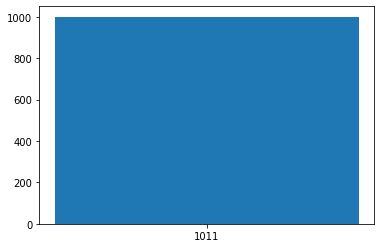

In [27]:
result = task_local.result()
print(f"measurement_counts: {result.measurement_counts}\n")
print(f"measurement_probabilities: {result.measurement_probabilities}\n")
plt.bar(result.measurement_counts.keys(), result.measurement_counts.values())
plt.show()

## Run in AWS Quantum Simulator


In [15]:
# Sets the AWS Account ID using STS
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]

# Specifies the S3 bucket to use for job output
s3_folder = (f"braket-output-{aws_account_id}", "outputs")

# Sets the quantum device to run the circuit on
device_aws = AwsQuantumSimulator(AwsQuantumSimulatorArns.QS1)

In [16]:
task_aws = device_aws.run(circ, s3_folder, shots=1000)

In [17]:
while task_aws.state() != "COMPLETED" :
    print(task_aws.state())
    time.sleep(3)
print(task_aws.state())

INITIALIZED
COMPLETED


measurement_counts: Counter({'1011': 1000})

measurement_probabilities: {'1011': 1.0}



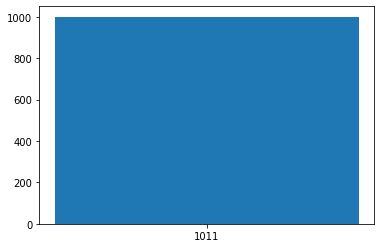

In [18]:
result = task_aws.result()
print(f"measurement_counts: {result.measurement_counts}\n")
print(f"measurement_probabilities: {result.measurement_probabilities}\n")
plt.bar(result.measurement_counts.keys(), result.measurement_counts.values())
plt.show()

In [19]:
# Sets the AWS Account ID using STS
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]

# Specifies the S3 bucket to use for job output
s3_folder = (f"braket-output-{aws_account_id}", "outputs")

# Sets the quantum device to run the circuit on
device = AwsQpu(AwsQpuArns.RIGETTI)

In [20]:
task = device.run(circ, s3_folder, shots=1000)

In [ ]:

print(task.state())

In [ ]:
result = task.result()
print(f"measurement_counts: {result.measurement_counts}\n")
print(f"measurement_probabilities: {result.measurement_probabilities}\n")
plt.bar(result.measurement_counts.keys(), result.measurement_counts.values())
plt.show()